## Codigo antiguo de libreria openet

In [1]:
# import openet.ssebop as oet
# import ee

# ee.Authenticate()
# ee.Initialize()
# ndvi_palette = ['#EFE7E1', '#003300']
# et_palette = [
#     'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
#     '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
# viridis_palette = ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725']
# # Definir la región de interés
# bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']
# band_names = [
#     'Band 1 - Coastal aerosol',
#     'Band 2 - Blue',
#     'Band 3 - Green',
#     'Band 4 - Red',
#     'Band 5 - Near Infrared (NIR)',
#     'Band 6 - Shortwave Infrared (SWIR) 1',
#     'Band 7 - Shortwave Infrared (SWIR) 2',
#     'Band 8 - Panchromatic',
#     'Band 9 - Cirrus'
# ]

# import matplotlib.pyplot as plt
# import numpy as np
# import requests
# from IPython.display import Image

# # landsat_img = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_038031_20130828')
# # bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']
# roi = ee.Geometry.Point([-71.26624015, -35.13008839])
# landsat_img = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
#                .filterDate('2024-07-01', '2024-10-05')
#                .filterBounds(roi)
#                .select(['SR_B4', 'SR_B3', 'SR_B2'])
#                .mean())
# # landsat_img = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044033_20170716')
# # landsat_img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_044033_20170801')
# image_size = 1024
# landsat_crs = landsat_img.select('SR_B3').projection().getInfo()['crs']
# landsat_region = roi.buffer(10000).bounds().getInfo()['coordinates']
# landsat_dt = ee.Date(landsat_img.get('system:time_start'))
# # print(landsat_img.get('system:time_start').getInfo())
#         #    .select(bands))

# roi = ee.Geometry.Point([-71.26624015, -35.13008839])  # Talca, Chile
# region = roi.buffer(1000).bounds().getInfo()

# # print(landsat_img.get('system:time_start').getInfo())

# image_url = landsat_img.select(['SR_B4', 'SR_B3', 'SR_B2'])\
#     .multiply([0.0000275, 0.0000275, 0.0000275])\
#     .add([-0.2, -0.2, -0.2])\
#     .getThumbURL({'min': 0.0, 'max': 0.3, 
#                   'region': landsat_region, 'dimensions': image_size})
# Image(image_url, embed=True, format='png')

# # NDVI
# model_obj = oet.Image.from_landsat_c2_sr(
#     landsat_img, 
#     tcorr_source='FANO',
#     et_reference_source='projects/openet/reference_et/gridmet/daily',
#     et_reference_band='etr',
#     et_reference_factor=1.0,
#     et_reference_resample='nearest',
# )

# image_url = model_obj.ndvi\
#     .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette, 
#                   'region':landsat_region, 'dimensions': image_size})
# Image(image_url, embed=True, format='png')

# image_url = model_obj.et_fraction\
#     .getThumbURL({'min': 0.0, 'max': 1.2, 'palette': et_palette, 
#                   'region': landsat_region, 'dimensions': image_size})
# Image(image_url, embed=True, format='png')

## De aqui en adelante es el codigo de la solucion

### Variables relevantes para calcular el ET

In [10]:
import ee
ee.Authenticate()
ee.Initialize()
import geeet
import geemap
import geemap.colormaps as cm
from geeet.eepredefined import landsat

ee.Initialize()
# -33.605887, -70.646652
# region = dict(type="Point", coordinates=[-70.6483, -33.4569])  # Santiago, Chile
region = dict(type="Point", coordinates=[-70.646652, -33.605887])  # Talca, Chile

coll =  landsat.collection(
    date_start = "2023-04-01",
    date_end = "2023-05-01",
    region = region, 
)
# More information about the collection
# coll.aggregate_array("LANDSAT_INDEX").getInfo()
# coll.first().bandNames().getInfo()

coll_with_era5 = landsat.collection(
    date_start = "2024-08-01",
    date_end = "2024-09-30",
    region = region, 
    era5 = True,
    timeZone="America/Santiago" # the time property will be set in local time (UTC -3 for this example)
)
# More information about the collection
# coll_with_era5.first().bandNames().getInfo()

landsat_era5_tseb_collection = coll_with_era5.map(geeet.tseb.tseb_series)
# More information about the collection
# landsat_era5_tseb_collection.first().bandNames().getInfo()

image = (
    landsat_era5_tseb_collection
    .filter(
        ee.Filter.eq("LANDSAT_INDEX", 
            coll_with_era5.aggregate_array("LANDSAT_INDEX").getInfo()[0]
        )
    )
    .first()
    .clip(
        ee.Geometry(region)
        .buffer(1000)   # 10km area around the point
        .bounds()        
    )
)

Map = geemap.Map()
Map.setCenter(*region["coordinates"], zoom=10)
ndvi_pal = cm.palettes.ndvi
red_pal = cm.palettes.YlOrRd
blue_pal = cm.palettes.YlGnBu

Map.addLayer(image, {'bands':['SR_B4', 'SR_B3', 'SR_B2'], 'min':0, 'max': 0.3}, 'Image')
Map.addLayer(image.select('albedo'), {'min':0, 'max':0.35}, 'Albedo (shortwave; Liang 2001)', False)
Map.addLayer(image.select('NDVI'), {'min':0, 'max':1, 'palette':ndvi_pal, 'opacity': 0.8}, 'NDVI')
Map.addLayer(image.select('radiometric_temperature'), {'min':20+273, 'max':50+273, 'palette':red_pal}, 'Landsat radiometric temperature (K)')
Map.addLayer(image.select('Rn'), {'min':0, 'max':500, 'palette':red_pal}, 'Net radiation (W/m²)', False)
Map.addLayer(image.select('LEc'), {'min':0, 'max':300, 'palette':blue_pal}, 'Latent heat flux (W/m²) from the canopy source', True)
Map

Map(center=[-33.605887, -70.646652], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

### Agregación del ET al dataframe

In [11]:
import geeet
from geeet.eepredefined import landsat

region = dict(type="Point", coordinates=[-70.646652, -33.605887])  # Santiago, Chile

# Define a custom workflow (TSEB model + LE extrapolation)
workflow = [
    geeet.tseb.tseb_series,
    landsat.extrapolate_LE    # this adds the "ET" band, in mm/day
]

landsat_era5_tseb_collection = landsat.mapped_collection(
    workflow,
    date_start = "2024-04-01",
    date_end = "2024-08-01",
    region = region, 
    era5 = True,
    timeZone="America/Santiago" # the time property will be set in local time (UTC -3 for this example)
)

landsat_era5_tseb_collection.first().bandNames().getInfo()

import geemap
import geemap.colormaps as cm

# Select one image by LANDSAT_INDEX:
image = (
    landsat_era5_tseb_collection
    .filter(ee.Filter.eq("LANDSAT_INDEX", 
    landsat_era5_tseb_collection.aggregate_array("LANDSAT_INDEX").getInfo()[0]
    ))
    .first()
    .clip(
        ee.Geometry(region)
        .buffer(1000)   # area around the point in meters
        .bounds()        
    )
    # .sampleRectangle(
    #     region=ee.Geometry(region).buffer(1000).bounds(),
    # )
)


Map = geemap.Map()
Map.setCenter(*region["coordinates"], zoom=12)
ndvi_pal = cm.palettes.ndvi
red_pal = cm.palettes.YlOrRd
blue_pal = cm.palettes.YlGnBu

Map.addLayer(image, {'bands':['SR_B4', 'SR_B3', 'SR_B2'], 'min':0, 'max': 0.3}, 'Image')
Map.addLayer(image.select('albedo'), {'min':0, 'max':0.35}, 'Albedo (shortwave; Liang 2001)', False)
Map.addLayer(image.select('NDVI'), {'min':0, 'max':1, 'palette':ndvi_pal, 'opacity': 0.8}, 'NDVI')
Map.addLayer(image.select('radiometric_temperature'), {'min':20+273, 'max':50+273, 'palette':red_pal}, 'Landsat radiometric temperature (K)')
Map.addLayer(image.select('Rn'), {'min':0, 'max':500, 'palette':red_pal}, 'Net radiation (W/m²)', False)
Map.addLayer(image.select('ET'), {'min':0, 'max':5, 'palette': ndvi_pal}, 'Evapotranspiration (mm/day)', True)

Map

# # Create a tif
# import os
# out_dir = os.path.join(os.path.expanduser("~"), "Downloads")
# out_file = os.path.join(out_dir, "image.tif")

# geemap.ee_export_image(image, filename=out_file, scale=30, region=region['coordinates'], file_per_band=False)


Map(center=[-33.605887, -70.646652], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

### Extracción del ET a un ndarray

In [49]:
# image.select('ET') to numpy array without reduce
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# Datos proporcionados por el usuario
datos_cultivo = {
    'Etapa': ['Etapa inicial', 'Etapa de desarrollo', 'Etapa de mitad de temporada', 'Etapa tardía'],
    'Duración (días)': [35, 40, 50, 25],
    'ETo (mm/día)': [5.0, 5.8, 6.3, 7.1],  # Feb- Mar, Mar, Abr-May, Jun (LANDSAT)
    'Kc': [0.45, 0.75, 1.15, 0.8]  # Valores de Kc para cada etapa
}

# Calcular ETc para cada etapa
etc = [(eto * kc) for eto, kc in zip(datos_cultivo['ETo (mm/día)'], datos_cultivo['Kc'])]
# Calcular el total de agua por cada etapa
agua_total = [et * dur for et, dur in zip(etc, datos_cultivo['Duración (días)'])]

# Añadir ETc y Agua Total al diccionario
datos_cultivo['ETc (mm/día)'] = etc
datos_cultivo['Agua Total (mm/m^2)'] = agua_total

# Crear un DataFrame
df_cultivo = pd.DataFrame(datos_cultivo)

df_cultivo


,Etapa,Duración (días),ETo (mm/día),Kc,ETc (mm/día),Agua Total (mm/m^2)
0,Etapa inicial,35,5.0,0.45,2.250,78.75
1,Etapa de desarrollo,40,5.8,0.75,4.350,174.00
2,Etapa de mitad de temporada,50,6.3,1.15,7.245,362.25
3,Etapa tardía,25,7.1,0.80,5.680,142.00


In [ ]:


# Select one image by LANDSAT_INDEX:
image = (
    landsat_era5_tseb_collection
    .filter(ee.Filter.eq("LANDSAT_INDEX", 
    landsat_era5_tseb_collection.aggregate_array("LANDSAT_INDEX").getInfo()[0]
    ))
    .first()
    .select('ET')
    .sampleRectangle(
        region=ee.Geometry(region).buffer(1000).bounds(),
    )
)

# Convert the data to a NumPy array
et_array = np.array(image.get('ET').getInfo())

# Plot the ET values as a square array
plt.figure(figsize=(10, 10))
plt.imshow(et_array, cmap='viridis', vmin=0, vmax=8)
plt.colorbar(label='ET (mm/day)')
plt.title('Evapotranspiration (ET)')
plt.show()

Processing 2024-01-01 to 2024-01-16
Processing 2024-01-17 to 2024-02-01
Processing 2024-02-02 to 2024-02-17
Processing 2024-02-18 to 2024-03-04
Processing 2024-03-05 to 2024-03-20
Processing 2024-03-21 to 2024-04-05
Processing 2024-04-06 to 2024-04-21
Processing 2024-04-22 to 2024-05-07
Processing 2024-05-08 to 2024-05-23
Processing 2024-05-24 to 2024-06-08
Processing 2024-06-09 to 2024-06-24
No images available for the interval 2024-06-09 to 2024-06-24: Image.bandNames: Parameter 'image' is required.
Processing 2024-06-25 to 2024-07-10
Processing 2024-07-11 to 2024-07-26
Processing 2024-07-27 to 2024-08-11
Processing 2024-08-12 to 2024-08-27
Processing 2024-08-28 to 2024-09-12
Processing 2024-09-13 to 2024-09-14
No images available for the interval 2024-09-13 to 2024-09-14: Image.bandNames: Parameter 'image' is required.


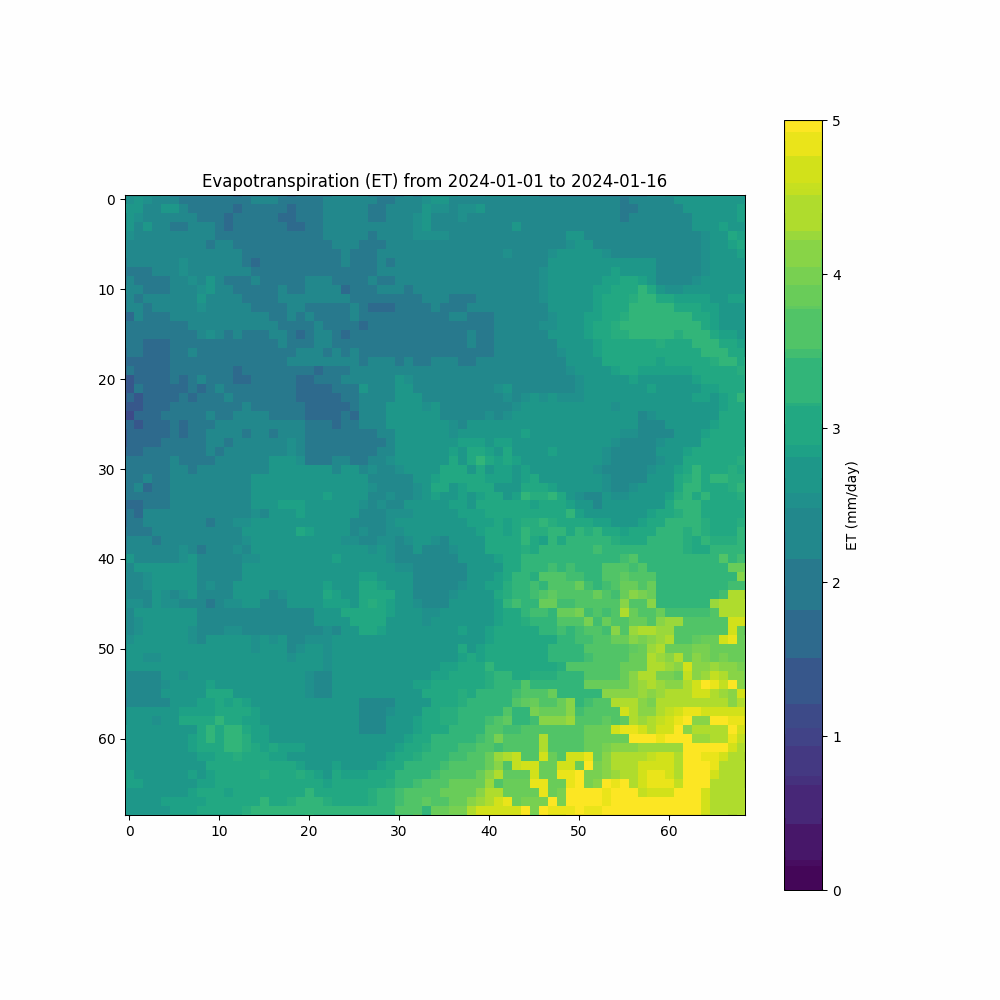

In [15]:
import openet.ssebop as oet
import ee
ee.Authenticate()
ee.Initialize()
import geeet
from geeet.eepredefined import landsat
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image as IPImage
from datetime import datetime, timedelta
import geemap.colormaps as cm
import imageio.v2 as imageio

def get_et_array(coordinates, start_date, end_date, polygon_coords=None):
    # Define the region
    if polygon_coords is not None:
        region = ee.Geometry.Polygon(polygon_coords)

    region = dict(type="Point", coordinates=coordinates)

    # Define a custom workflow (TSEB model + LE extrapolation)
    workflow = [
        geeet.tseb.tseb_series,
        landsat.extrapolate_LE    # this adds the "ET" band, in mm/day
    ]

    landsat_era5_tseb_collection = landsat.mapped_collection(
        workflow,
        date_start = start_date,
        date_end = end_date,
        region = region, 
        era5 = True,
        timeZone="America/Santiago" # the time property will be set in local time (UTC -3 for this example)
    )

    landsat_era5_tseb_collection.first().bandNames().getInfo()

    bands = ['SR_B4', 'SR_B3', 'SR_B2']
    image = (
        landsat_era5_tseb_collection
        .filter(
            ee.Filter.eq("LANDSAT_INDEX", 
                landsat_era5_tseb_collection.aggregate_array("LANDSAT_INDEX").getInfo()[0]
            )
        )
        .first()
        .select(bands + ['ET'])
        .clip(
            ee.Geometry(region)
            .buffer(1000)   # area around the point in meters
            .bounds()        
        )
    )
    et = np.array(image.get('ET').getInfo())
    rgb = np.dstack([np.array(image.get(b).getInfo()) for b in bands])
    return rgb, et

# Example usages
# coordinates = [-71.26624015, -35.13008839]
coordinates = [-70.6483, -33.4569]

# Example usage
# polygon_coords = [
#     [[-70.6483, -33.4569],
#      [-70.6483, -33.4469],
#      [-70.6383, -33.4469],
#      [-70.6383, -33.4569],
#      [-70.6483, -33.4569]]  # Ensure the polygon is closed
# ]

# Define the start and end dates
start_date = datetime.strptime("2024-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2024-09-14", "%Y-%m-%d")

# Generate date ranges with 16-day intervals
date_ranges = []
current_start_date = start_date

while current_start_date < end_date:
    current_end_date = current_start_date + timedelta(days=15)
    if current_end_date > end_date:
        current_end_date = end_date
    date_ranges.append((current_start_date.strftime("%Y-%m-%d"), current_end_date.strftime("%Y-%m-%d")))
    current_start_date = current_end_date + timedelta(days=1)

# Initialize a list to store the images
images = []
for start_date, end_date in date_ranges:
    print(f'Processing {start_date} to {end_date}')
    try:
        rgb, et = get_et_array(coordinates, start_date, end_date)
        # Plot the ET values as a square array
        plt.figure(figsize=(10, 10))
        plt.imshow(et_array, cmap='viridis', vmin=0, vmax=5)
        plt.colorbar(label='ET (mm/day)')
        plt.title(f'Evapotranspiration (ET) from {start_date} to {end_date}')
        
        # Save the plot to a temporary file
        temp_filename = f'./imgs/et_{start_date}_{end_date}.png'
        plt.savefig(temp_filename)
        plt.close()
        
        # Read the image and append to the list
        images.append(imageio.imread(temp_filename))
    except Exception as e:
        print(f'No images available for the interval {start_date} to {end_date}: {e}')

# Create a GIF from the images
gif_filename = './imgs/et_monthly.gif'
imageio.mimsave(gif_filename, images, duration=1)

# Display the GIF
IPImage(filename=gif_filename)


In [25]:
import geeet
from geeet.eepredefined import landsat
import ee

# Initialize the Earth Engine module
ee.Initialize()

# Define the region for Santiago, Chile
region = dict(type="Point", coordinates=[-70.6483, -33.4569])

# Define a custom workflow (TSEB model + LE extrapolation)
workflow = [
    geeet.tseb.tseb_series,
    landsat.extrapolate_LE  # This adds the "ET" band, in mm/day
]

# Create a collection with ET
landsat_era5_tseb_collection = landsat.mapped_collection(
    workflow,
    date_start="2024-04-01",
    date_end="2024-08-01",
    region=region,
    era5=True,
    timeZone="America/Santiago"
)

# Select one image by LANDSAT_INDEX
image = (
    landsat_era5_tseb_collection
    .filter(ee.Filter.eq("LANDSAT_INDEX", 
    landsat_era5_tseb_collection.aggregate_array("LANDSAT_INDEX").getInfo()[0]
    ))
    .first()
)

# Select the ET band
et_band = image.select('ET')

# Define a function to retrieve pixel values
def get_et_array(et_band):
    # Sample the image at the specified region
    et_sampled = et_band.sampleRegion(
        collection=ee.FeatureCollection([ee.Feature(ee.Geometry.Point(region["coordinates"]))]),
        scale=30,  # Adjust scale as necessary
        geometries=True
    )
    return et_sampled

# Get the ET values as a dictionary
et_values = get_et_array(et_band).getInfo()

# Extract the values from the dictionary
et_array = np.array([feature['properties']['ET'] for feature in et_values['features']])

# Print the ET NumPy array
print(et_array)


AttributeError: 'Image' object has no attribute 'sampleRegion'

In [1]:
import numpy as np
import geeet

list_inputs = dict(
    Tr = [295, 295],    # Radiometric temperature (K)
    Alb = [0.2, 0.2],   # Albedo (-)
    NDVI = [0.8, 0.8],  # NDVI (-) 
    P = [95500, 95500], # Surface pressure (Pa)
    Ta = [290, 290],    # Air temperature (K)
    Td = [287, 287],    # Dewpoint temperature (K)
    U = [5,5],          # Wind speed (m/s)
    Sdn = [800, 400],   # Shortwave downward radiation (W/m²)
    Ldn = [350, 200]    # Longwave downward radiation (W/m²)
)
np_inputs = {key:np.array(value) for key,value in list_inputs.items()}

scalar_inputs = dict(
    doy = 1,            # Day of year
    time = 11,          # Local hour
    Vza = 0,            # Viewing zenith angle (degrees)
    longitude = 38.25,  # Longitude (degrees)
    latitude = 30,      # Latitude (degrees)
    zU = 10,            # Wind measurement height (m)
    zT = 2              # Temperature measurement height (m)
)

et_list = geeet.tseb.tseb_series(**list_inputs, **scalar_inputs)   # This
et_np = geeet.tseb.tseb_series(**np_inputs, **scalar_inputs)       # and this result are equal.
f = lambda s,k,a,b,p: f'{s} {np.array2string(np.array(a[k]), precision=p)} | {np.array2string(np.array(b[k]), precision=p)}'
print('Energy balance components                         et_list           et_np')
print(f('Net radiation (W/m²):                          ', "Rn", et_list, et_np, 1))
print(f('Net radiation (W/m²) from canopy source:       ', "Rnc", et_list, et_np, 1))
print(f('Net radiation (W/m²) from soil source:         ', "Rns", et_list, et_np, 1))
print(f('Latent heat flux (W/m²):                       ', "LE", et_list, et_np, 1))
print(f('Latent heat flux (W/m²) from canopy source:    ', "LEc", et_list, et_np, 1))
print(f('Latent heat flux (W/m²) from soil source:      ', "LEs", et_list, et_np, 1))
print(f('Sensible heat flux (W/m²) from canopy source:  ', "Hc", et_list, et_np, 1))
print(f('Sensible heat flux (W/m²) from soil source:    ', "Hs", et_list, et_np, 1))
print(f('Ground heat flux (W/m²):                       ', "G", et_list, et_np, 1))

Energy balance components                         et_list           et_np
Net radiation (W/m²):                           [574.5 104.5] | [574.5 104.5]
Net radiation (W/m²) from canopy source:        [401.7  73.1] | [401.7  73.1]
Net radiation (W/m²) from soil source:          [172.8  31.4] | [172.8  31.4]
Latent heat flux (W/m²):                        [336.5  77.9] | [336.5  77.9]
Latent heat flux (W/m²) from canopy source:     [310.5  56. ] | [310.5  56. ]
Latent heat flux (W/m²) from soil source:       [26.  21.8] | [26.  21.8]
Sensible heat flux (W/m²) from canopy source:   [91.2 17. ] | [91.2 17. ]
Sensible heat flux (W/m²) from soil source:     [98.7  0.9] | [98.7  0.9]
Ground heat flux (W/m²):                        [48.1  8.7] | [48.1  8.7]


In [3]:
import xarray as xr

band_names = {
    "Alb": "albedo",
    "NDVI":"NDVI",
    "Tr":"radiometric_temperature",
    "Ta":"air_temperature",
    "Td":"dewpoint_temperature",
    "P":"surface_pressure",
    "U":"wind_speed",
    "Sdn":"solar_radiation",
    "Ldn":"thermal_radiation",
}
    
xr_inputs = xr.merge(
    [xr.DataArray(list_inputs[k]).rename(v) for k,v in band_names.items()])

et_xr = geeet.tseb.tseb_series(xr_inputs, **scalar_inputs)
et_xr

<xarray.Dataset> Size: 400B
Dimensions:                  (dim_0: 2)
Dimensions without coordinates: dim_0
Data variables: (12/25)
    albedo                   (dim_0) float64 16B 0.2 0.2
    NDVI                     (dim_0) float64 16B 0.8 0.8
    radiometric_temperature  (dim_0) int64 16B 295 295
    air_temperature          (dim_0) int64 16B 290 290
    dewpoint_temperature     (dim_0) int64 16B 287 287
    surface_pressure         (dim_0) int64 16B 95500 95500
    ...                       ...
    Tc                       (dim_0) float64 16B 293.2 295.1
    Tac                      (dim_0) float64 16B 300.3 294.8
    ra                       (dim_0) float64 16B 40.87 297.9
    rs                       (dim_0) float64 16B 79.94 192.4
    rx                       (dim_0) float64 16B 11.68 31.11
    it                       (dim_0) float64 16B 0.0 2.0

In [4]:
import ee
ee.Initialize()

# Transform the list_inputs dictionary to lists of dictionaries
list_inputs_t = []
for i in range(2):
    list_inputs_t.append(
        {key: value[i] for key, value in list_inputs.items()}
    )
# Separate constant ee.Images:
ee_images = []
for x in list_inputs_t:
    ee_images.append(
        ee.Image(ee.Dictionary(x).toImage())
        # Rename (same names as in the xarray example)
        .select(["Alb", "NDVI", "Tr", "Td","Ta", "P", "U", "Sdn", "Ldn"],
                ["albedo",
                "NDVI",
                "radiometric_temperature",
                "dewpoint_temperature",
                "air_temperature",
                "surface_pressure",
                "wind_speed",
                "solar_radiation",
                "thermal_radiation"])
        .set({**scalar_inputs,**{"viewing_zenith": scalar_inputs["Vza"]}})
    )
ee_image_collection = ee.ImageCollection(ee_images)  # We will also prepare an ee.ImageCollection for demonstrating how to map the ET model. 

In [5]:
et_ee = geeet.tseb.tseb_series(ee_images[0])

In [6]:
et_ee.bandNames().getInfo()

['albedo',
 'NDVI',
 'radiometric_temperature',
 'dewpoint_temperature',
 'air_temperature',
 'surface_pressure',
 'wind_speed',
 'solar_radiation',
 'thermal_radiation',
 'Tc',
 'Ts',
 'Tac',
 'Hc',
 'Hs',
 'LEc',
 'LEs',
 'Ra',
 'Rs',
 'Rx',
 'Ustar',
 'alphaPT',
 'iteration',
 'LE',
 'H',
 'G',
 'Rn',
 'Rns',
 'Rnc']

In [7]:
def pt_reducer(img):
    return img.reduceRegion(reducer=ee.Reducer.mean(), 
                               geometry=dict(type="Point", 
                               coordinates=[
                                   scalar_inputs["longitude"], 
                                   scalar_inputs["latitude"]
                                ]),
                               scale=30)

In [8]:
et_ee_pt = pt_reducer(et_ee).getInfo()  # This waits for the result from EE interactive environment. 

L = lambda s,k,a,b: f'{s} {a[k][0]:.2f} | {b[k]:.2f}'  # a: the np array result (list of 2 pts); b: our single ee pt
print(L('Net radiation (W/m²):                          ', "Rn", et_np, et_ee_pt))
print(L('Net radiation (W/m²) from canopy source:       ', "Rnc",et_np, et_ee_pt))
print(L('Net radiation (W/m²) from soil source:         ', "Rns",et_np, et_ee_pt))
print(L('Latent heat flux (W/m²):                       ', "LE", et_np, et_ee_pt))
print(L('Latent heat flux (W/m²) from canopy source:    ', "LEc",et_np, et_ee_pt))
print(L('Latent heat flux (W/m²) from soil source:      ', "LEs",et_np, et_ee_pt))
print(L('Sensible heat flux (W/m²) from canopy source:  ', "Hc", et_np, et_ee_pt))
print(L('Sensible heat flux (W/m²) from soil source:    ', "Hs", et_np, et_ee_pt))
print(L('Ground heat flux (W/m²):                       ', "G",  et_np, et_ee_pt))

Net radiation (W/m²):                           574.52 | 574.52
Net radiation (W/m²) from canopy source:        401.67 | 401.67
Net radiation (W/m²) from soil source:          172.85 | 172.85
Latent heat flux (W/m²):                        336.52 | 336.52
Latent heat flux (W/m²) from canopy source:     310.48 | 310.48
Latent heat flux (W/m²) from soil source:       26.04 | 26.04
Sensible heat flux (W/m²) from canopy source:   91.19 | 91.19
Sensible heat flux (W/m²) from soil source:     98.71 | 98.71
Ground heat flux (W/m²):                        48.10 | 48.10


In [9]:
et_ee_collection = ee_image_collection.map(geeet.tseb.tseb_series)

In [10]:
feature_collection = dict(type="FeatureCollection", features=[
    dict(type="Feature", properties=dict(name="my point"),
         geometry=dict(type="Point", 
        coordinates = [scalar_inputs["longitude"], 
                      scalar_inputs["latitude"]])
)]) 

In [11]:
from geeet.eepredefined import reducers

bands = ["LE", "LEs", "LEc", "Hs", "Hc", "Rn", "Rnc", "Rns", "G"]

reduced = reducers.image_collection(feature_collection,
    img_collection = ee.ImageCollection(et_ee_collection  # The image collection to reduce. Here our two-image collection
    # However, the reducers module requires that each image have a system:time_start, so let's put one here:
                    .map(lambda img: img.set({"system:time_start": 1704096000000})),
    ), 
    mean_bands = bands,  # The bands to reduce using ee.Reudcer.mean
    feature_properties = ["name"] # Optionally keep properties from each feature. 
) # This is a ee.FeatureCollection

# For easier comparison with the numpy array aexample, let's 
# request the output as a dictionary of arrays:
band_agg_dict = {band: reduced.aggregate_array(band) for band in bands}
ee_outputs = ee.Dictionary(band_agg_dict).getInfo()

# Finally, let's compare these with the on-premises results:
print('Energy balance components                         np_outputs           ee_outputs')
print(f('Net radiation (W/m²):                          ', "Rn",  et_np, ee_outputs, 1))
print(f('Net radiation (W/m²) from canopy source:       ', "Rnc", et_np, ee_outputs, 1))
print(f('Net radiation (W/m²) from soil source:         ', "Rns", et_np, ee_outputs, 1))
print(f('Latent heat flux (W/m²):                       ', "LE",  et_np, ee_outputs, 1))
print(f('Latent heat flux (W/m²) from canopy source:    ', "LEc", et_np, ee_outputs, 1))
print(f('Latent heat flux (W/m²) from soil source:      ', "LEs", et_np, ee_outputs, 1))
print(f('Sensible heat flux (W/m²) from canopy source:  ', "Hc",  et_np, ee_outputs, 1))
print(f('Sensible heat flux (W/m²) from soil source:    ', "Hs",  et_np, ee_outputs, 1))
print(f('Ground heat flux (W/m²):                       ', "G",   et_np, ee_outputs, 1))

Energy balance components                         np_outputs           ee_outputs
Net radiation (W/m²):                           [574.5 104.5] | [574.5 104.5]
Net radiation (W/m²) from canopy source:        [401.7  73.1] | [401.7  73.1]
Net radiation (W/m²) from soil source:          [172.8  31.4] | [172.8  31.4]
Latent heat flux (W/m²):                        [336.5  77.9] | [336.5  77.9]
Latent heat flux (W/m²) from canopy source:     [310.5  56. ] | [310.5  56. ]
Latent heat flux (W/m²) from soil source:       [26.  21.8] | [26.  21.8]
Sensible heat flux (W/m²) from canopy source:   [91.2 17. ] | [91.2 17. ]
Sensible heat flux (W/m²) from soil source:     [98.7  0.9] | [98.7  0.9]
Ground heat flux (W/m²):                        [48.1  8.7] | [48.1  8.7]
